# Derive a probability distribution for raw data using histograms and kernel density estimates

In [7]:
'''Initialise'''
%matplotlib notebook
#import mpld3
#mpld3.enable_notebook()
import numpy as np
from astropy.stats import histogram
import matplotlib.pyplot as plt

def setPlotParams():
    plt.figure(figsize = (8, 8))
    params = {'legend.fontsize': 'x-large',
              'axes.labelsize':20,
              'axes.titlesize':20,
              'xtick.labelsize':20,
              'ytick.labelsize':20,
              'text.usetex': True,
              'text.latex.preamble': r'\usepackage{bm}'}
    plt.rcParams.update(params)
    return plt

def getdata():
    #d = np.loadtxt('parameters_bg_ancestor_T_profile.dat', comments = '#')
    #log_m = np.log10(d[:, 14])
    #e_log_m = d[:, 15]/d[:, 14]/np.log(10.)
    d = np.loadtxt('data.dat', comments = '#')
    log_m = d[:, 0]
    e_log_m = d[:, 1]/d[:, 0]/np.log(10.) #propagating uncertainties into log_m
    return log_m, e_log_m

#Extract the masses and related uncertainties
log_m, e_log_m = getdata()


# Histogram shape is very sensitive to bin size!!!

<IPython.core.display.Javascript object>


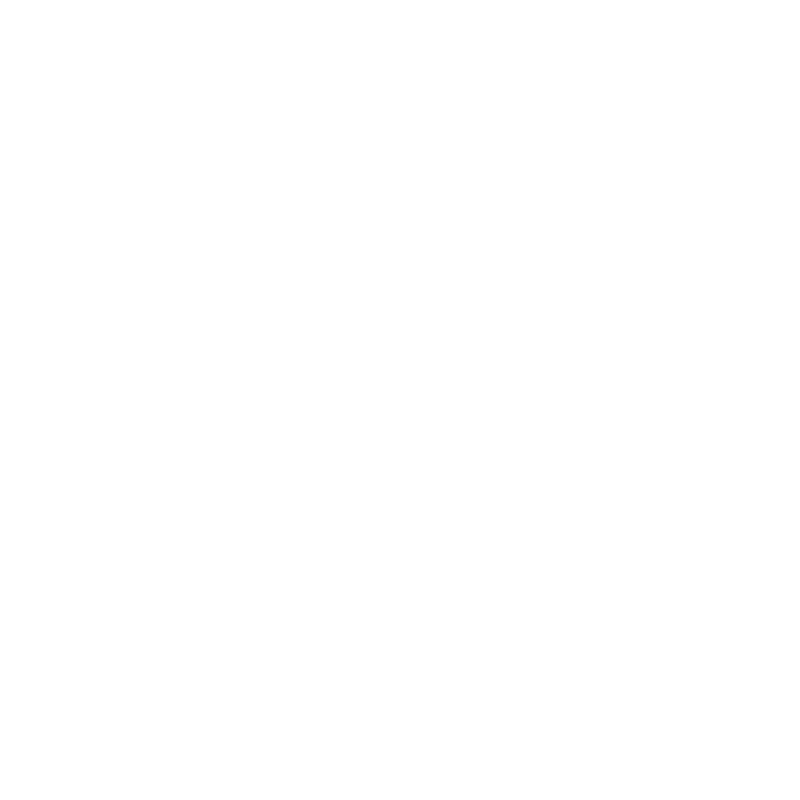

<IPython.core.display.Javascript object>


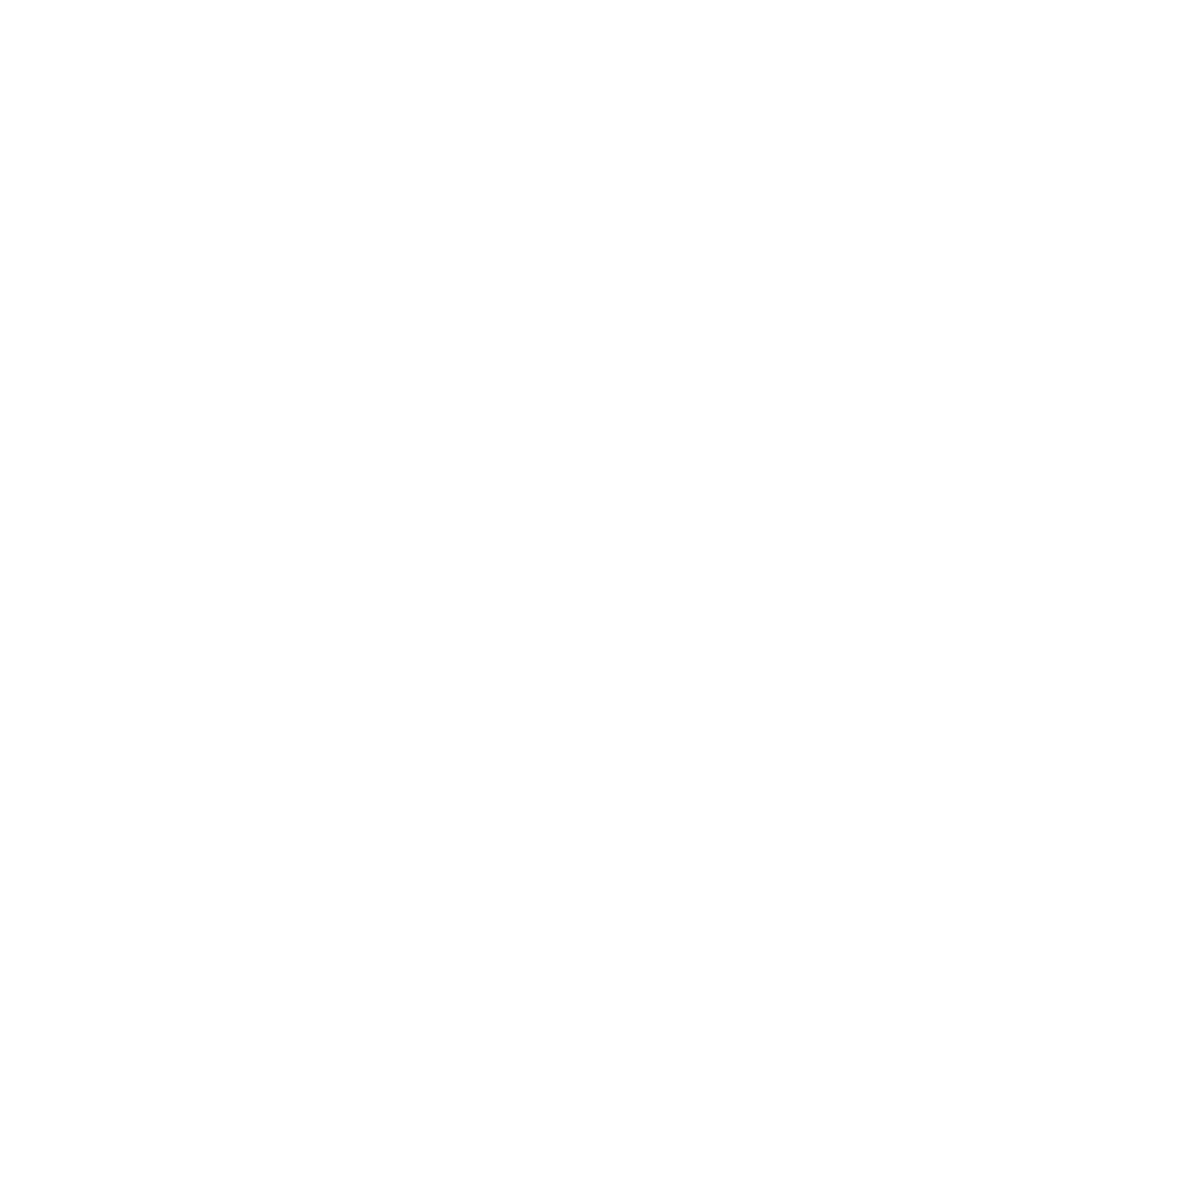

<IPython.core.display.Javascript object>


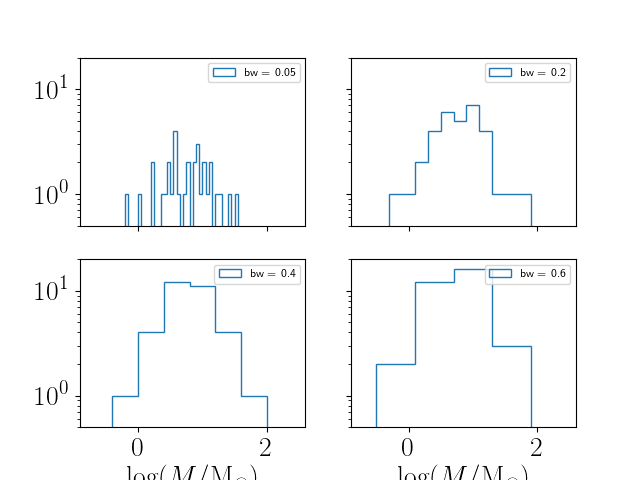

Text(0.5, 0, '$\\log(M/{\\rm M}_{\\odot})$')

In [8]:
##########first, vary the bin size
bws = [0.05, 0.2, 0.4, 0.6]
plt = setPlotParams()
_ = plt.figure(figsize = (12, 12))
f, axes = plt.subplots(2, 2, sharey = 'row', sharex = 'col')
axs = list(axes.flatten())
for iax, bw in enumerate(bws):
    bin_min = round(round(min(log_m), 1) - bw/2, 1)
    bin_max = round(round(max(log_m), 1) + bw/2, 1)
    bins = np.arange(bin_min, bin_max + bw, bw)
    _ = axs[iax].hist(log_m, bins = bins, label = 'bw = {}'.format(bw), histtype = 'step', log = True)
    axs[iax].set_xlim([-0.9, 2.6]); axs[iax].set_ylim([0.5, 20]) #to match Gennaro's plot
    axs[iax].legend(loc = 'best', prop = {'size': 8})
axs[2].set_xlabel(r'$\log(M/{\rm M}_{\odot})$')
axs[3].set_xlabel(r'$\log(M/{\rm M}_{\odot})$')


# The histogram shape can also change with bin location!!!

<IPython.core.display.Javascript object>


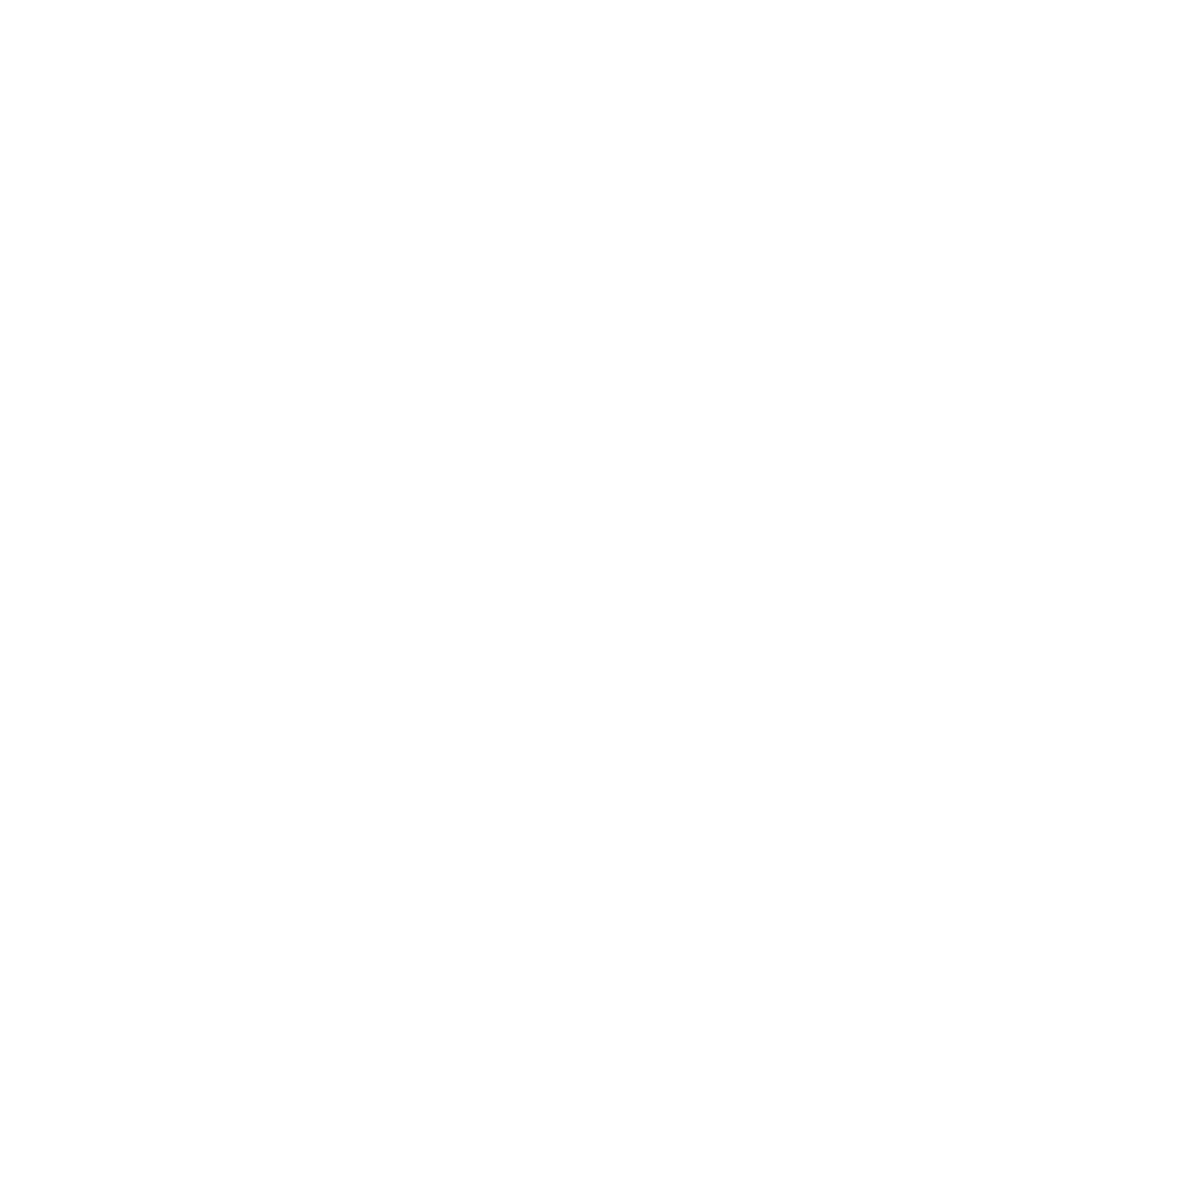

<IPython.core.display.Javascript object>


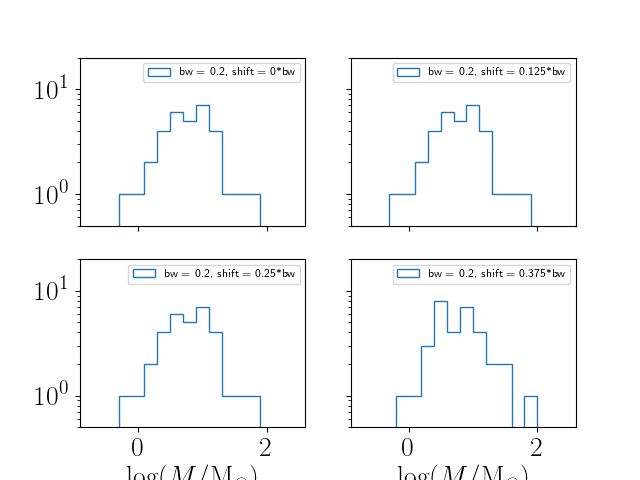

<IPython.core.display.Javascript object>


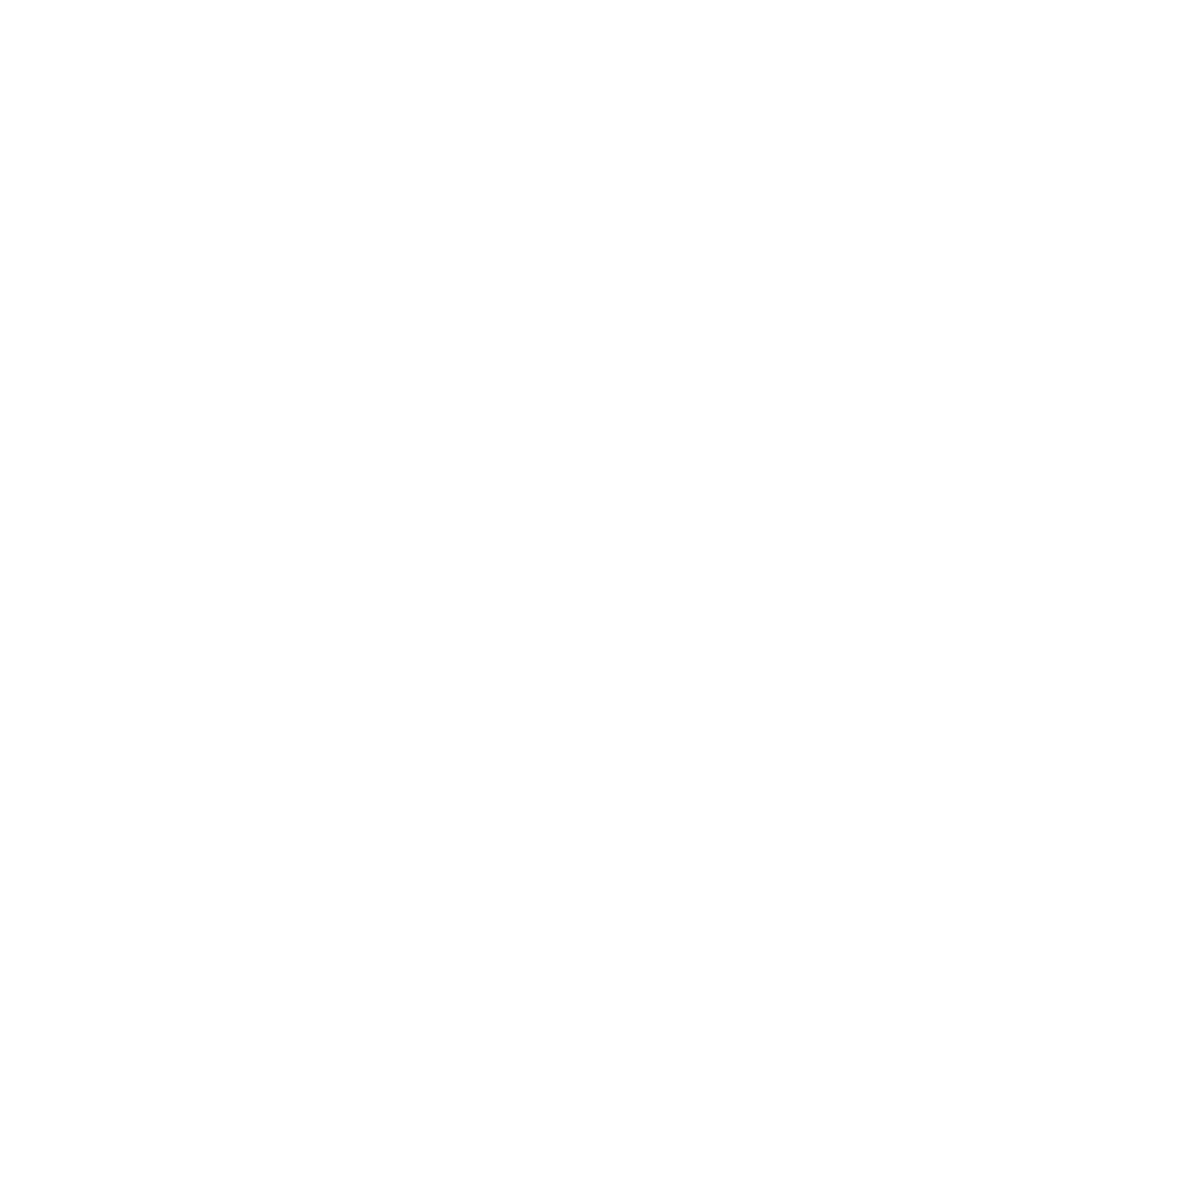

<IPython.core.display.Javascript object>


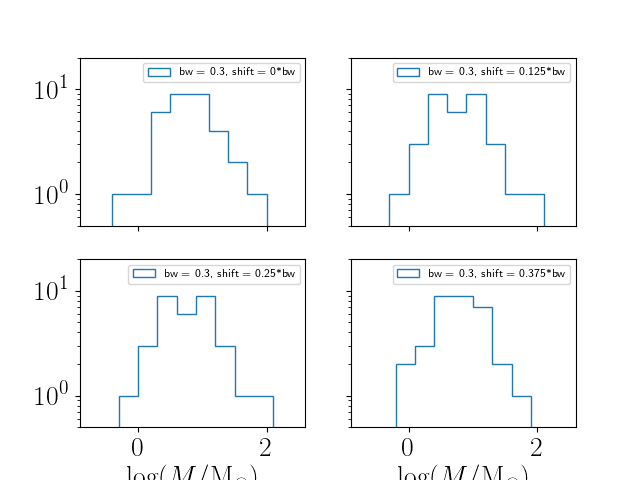

In [9]:
##########second, vary the bin locations for a fixed bandwidth.
bws = [0.2, 0.3]
locs = [0, 1/8, 1/4, 3/8]
for bw in bws:
    plt.figure(figsize = (12, 12))
    f, axes = plt.subplots(2, 2, sharey = 'row', sharex = 'col')
    axs = list(axes.flatten())
    for iax, loc in enumerate(locs):
        bin_min = round(round(min(log_m), 1) - bw/2 + bw*loc, 1)
        bin_max = round(round(max(log_m), 1) + bw/2 + bw*loc, 1)
        bins = np.arange(bin_min, bin_max + bw, bw)
        _ = axs[iax].hist(log_m, bins = bins, label = 'bw = {}, shift = {}*bw'.format(bw, loc), histtype = 'step', log = True)
        axs[iax].set_xlim([-0.9, 2.6]); axs[iax].set_ylim([0.5, 20]) #to match Gennaro's plot
        axs[iax].legend(loc = 'best', prop = {'size': 8})
    axs[2].set_xlabel(r'$\log(M/{\rm M}_{\odot})$')
    axs[3].set_xlabel(r'$\log(M/{\rm M}_{\odot})$')

# There are many ways to automatically compute the bin width, these methods can be accessed by setting the 'bins' keyword to a string. Some examples are shown here.

<IPython.core.display.Javascript object>


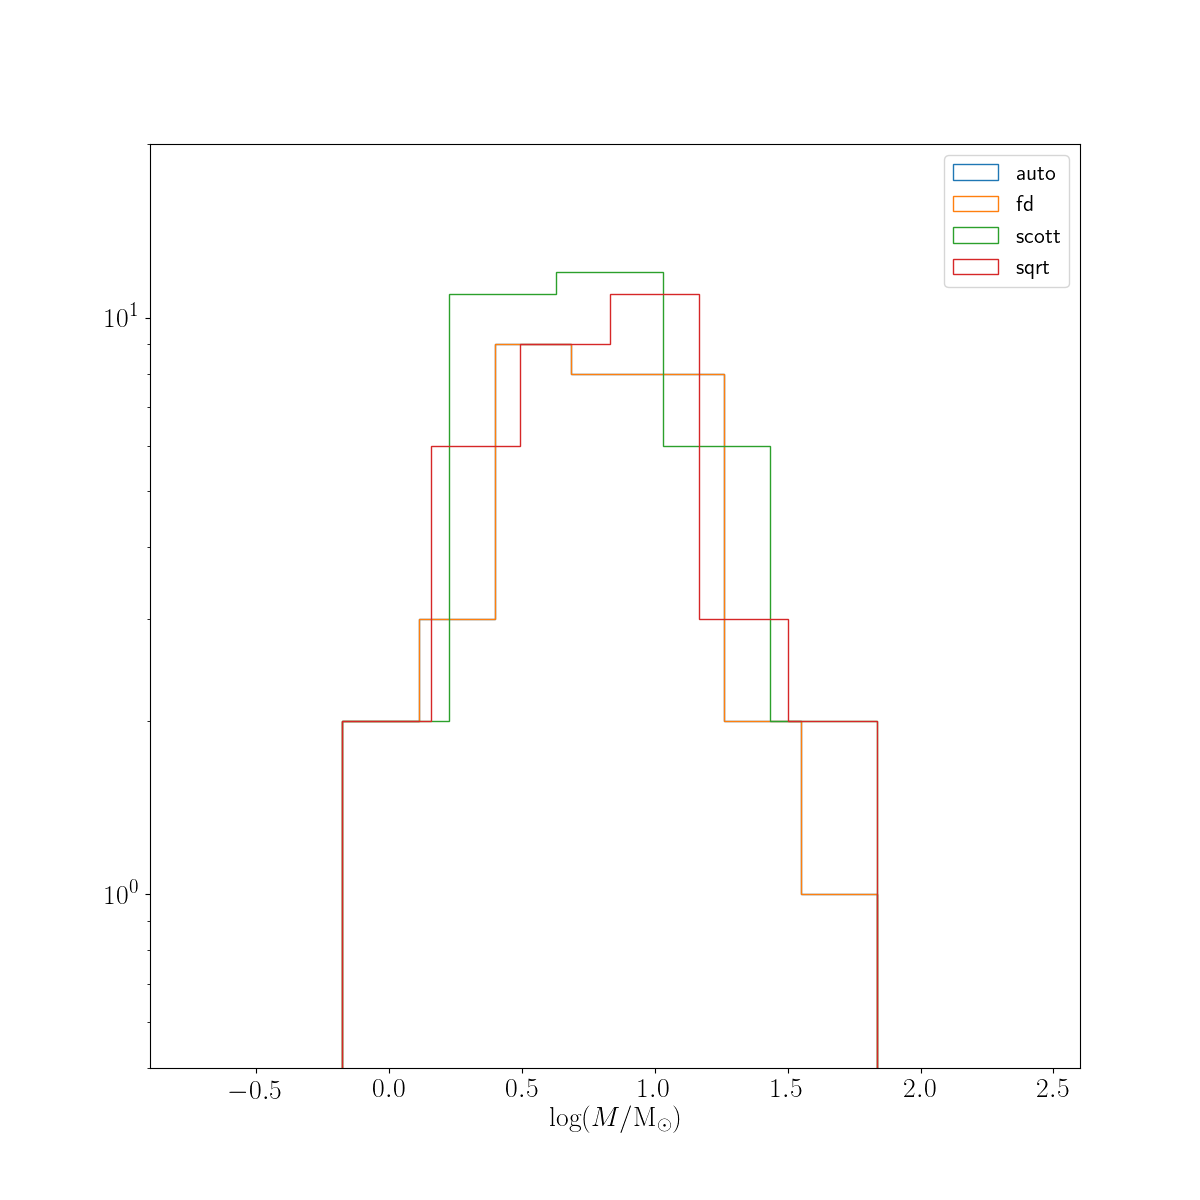

In [10]:
##########third, matplotlib histograms with automated binning
plt.figure(figsize = (12, 12))
bws = ['auto', 'fd', 'scott', 'sqrt']
for bw in bws:
    _ = plt.hist(log_m, bins = bw, histtype = 'step', log = True, label = bw)
plt.xlim(-0.9, 2.6); plt.ylim(0.5, 20)
plt.xlabel(r'$\log(M/{\rm M}_{\odot})$')
plt.legend(loc = 'best', prop = {'size': 16})

# Only the 'auto' option produces a histogram with a central dip. The KDE produces a flat distribution in the centre (see below), which is consistent with the other histograms

# Bayesian methods for bin choice are also available!
## In particular, the Bayesian Blocks method (Scargle et al. 2012) can generate histograms with (a) variable bin widths and (c) uncertainties.

In [11]:
##########fourth, use astropy's hist module to plot Bayesian implementations of bin width.
####Bayesian Blocks described in the appendix of Scargle+ 2012.
from astropy.visualization import hist as aphist
import warnings
plt.figure(figsize = (12, 12))
bins = ['knuth', 'blocks']
for bintype in bins:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore') #Ignore Bayesian Block p0 warning
        aphist(log_m, bins = bintype, histtype = 'step', label = bintype, log = True)
plt.xlim(-0.9, 2.6); plt.ylim(0.5, 20)
plt.xlabel(r'$\log(M/{\rm M}_{\odot})$')
plt.legend(loc = 'best', prop = {'size': 16})

<IPython.core.display.Javascript object>

# The Bayesian Blocks algorithm generated a single bin for this dataset :D

# For sparse and/or low-S/N data, it is important to propagate the uncertainties into the histogram!!

<Figure size 576x576 with 0 Axes>

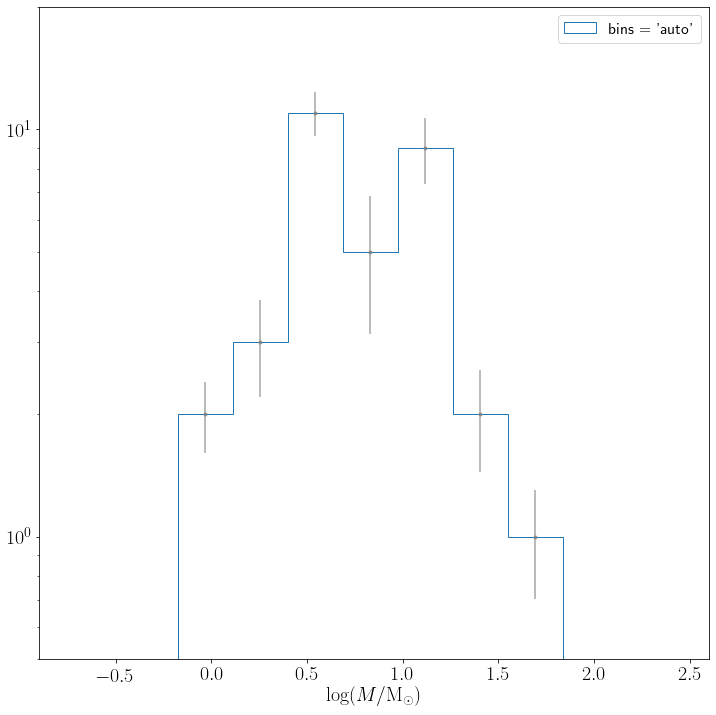

[0.28048582 0.46385825 0.40847141 0.82927482 0.55664287 0.39765874
 0.2983144 ] 0.4084714074444312


In [41]:
##########fifth, matplotlib histogram set to auto bin, and incorporating uncertainties
"""(method: https://stats.stackexchange.com/questions/214287/calculating-
uncertainties-for-histogram-bins-of-experimental-data-with-known-mea)"""
from scipy.special import erf
plt.figure(figsize = (12, 12))
h, bin_edges, _ = plt.hist(log_m, bins = 'auto', histtype = 'step', log = True, label = "bins = 'auto'")
nbins = len(bin_edges) - 1
ndata = len(log_m)
t = np.zeros((ndata, nbins+1))
p = np.zeros((ndata, nbins))
stderr_h = np.zeros(nbins)
for i in range(ndata):
    t[i, 0] = erf((bin_edges[0] - log_m[i])/np.sqrt(2)/e_log_m[i])
    for j in range(1, nbins+1):
        t[i, j] = erf((bin_edges[j] - log_m[i])/np.sqrt(2)/e_log_m[i])
        p[i, j-1] = 0.5 * (t[i, j] - t[i, j-1])
for j in range(nbins):
    stderr_h[j] = (p[:,j]*(1 - p[:, j])).sum()
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.errorbar(bin_centers, h, yerr = stderr_h, fmt = '.', c = 'gray', alpha = 0.7, zorder = 6)
plt.xlim(-0.9, 2.6); plt.ylim(0.5, 20)
plt.xlabel(r'$\log(M/{\rm M}_{\odot})$')
plt.legend(loc = 'best', prop = {'size': 16})
#save the bin edges, centers and values
bin_edges_with_unc = bin_edges
bin_centers_with_unc = bin_centers
h_with_unc = h
h_unc = stderr_h
print(stderr_h/np.sqrt(h), np.median(stderr_h/np.sqrt(h)))


# Summary:
## Binning data is bad because we lost information. Histogram representations of data are problematic because the shape of the histogram depends on the bin widths and locations chosen.
## There are many prescriptions available to automate this choice (this is important for reproducibility and consistency).
## For more information, see options for the bins keyword.

# ------------------------------------------------------------------
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# ------------------------------------------------------------------

# A kernel density estimate is a continuous function that is a fit to the raw data. 

# Each point in the raw data is represented by a kernel function (e.g., a Gaussian) with some bandwidth.


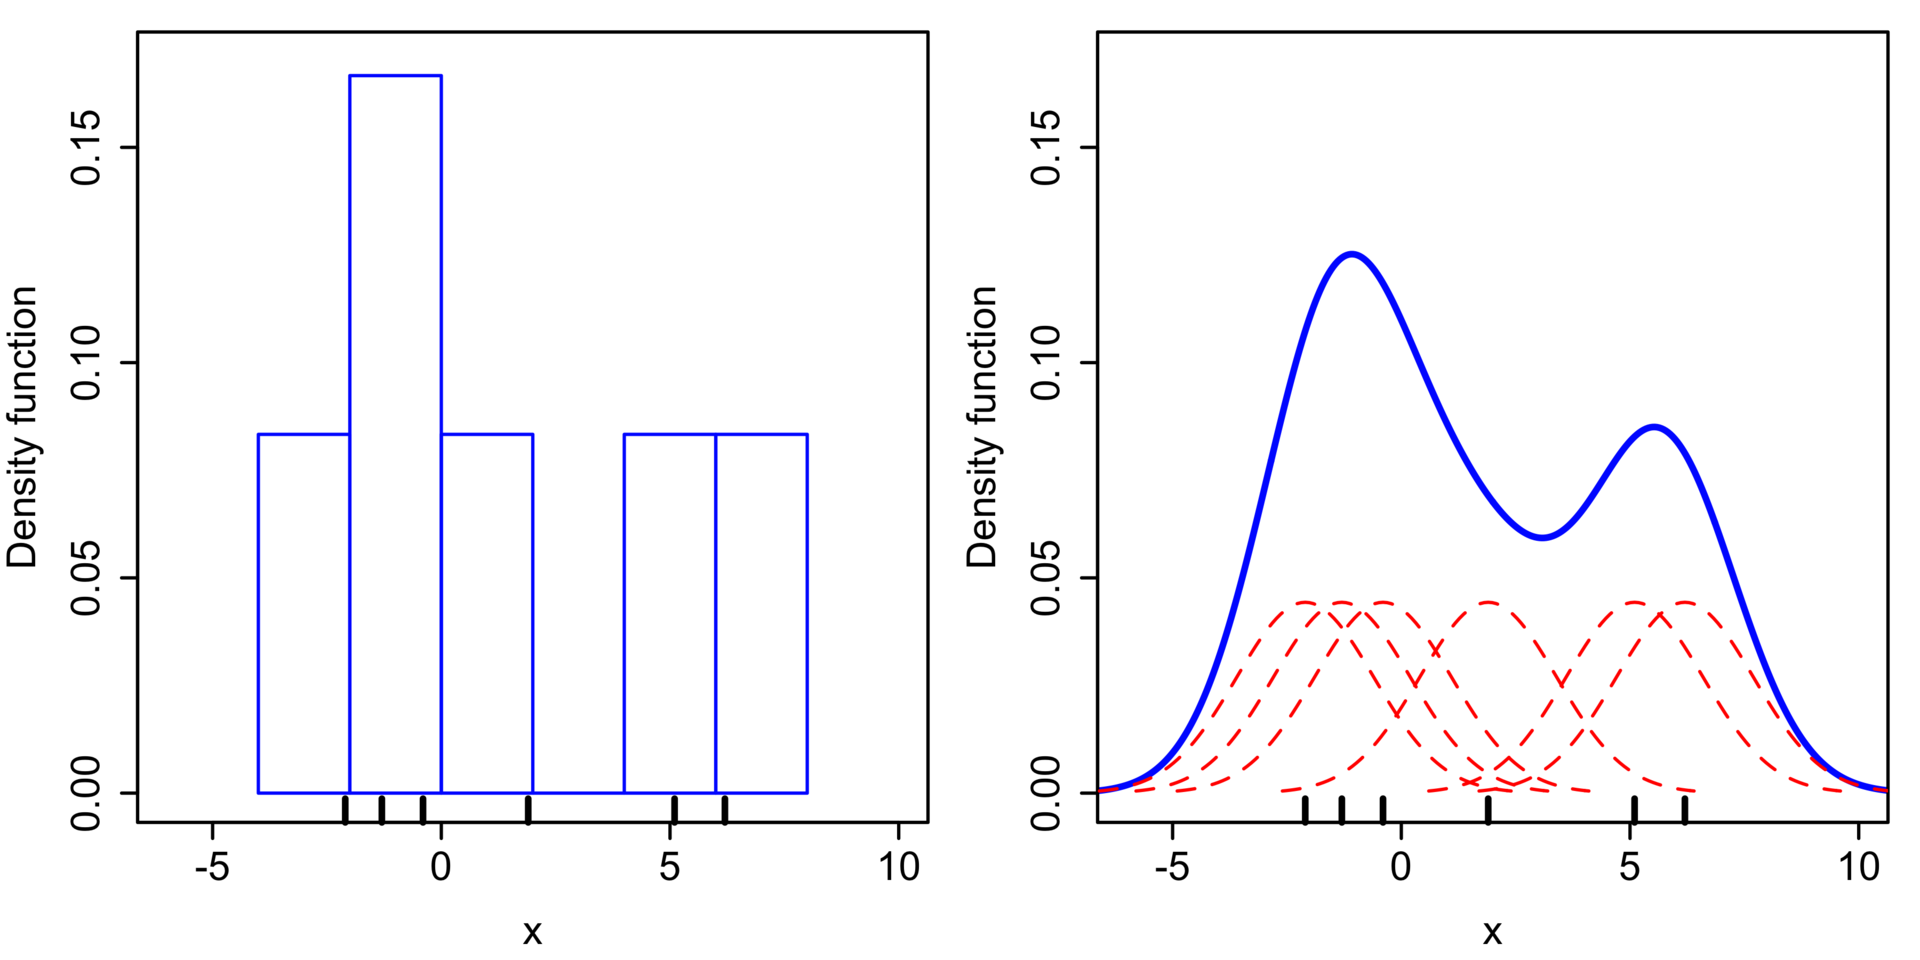




# KDEs are nonparametric fits to data!
# The actual choice of kernel is not important, but choice of bandwidth is.
# Many choices available, but for most purposes the default one works well.

# Let's fit a KDE with a Gaussian kernel to our data, using an "auto" bin width computation.

<Figure size 576x576 with 0 Axes>

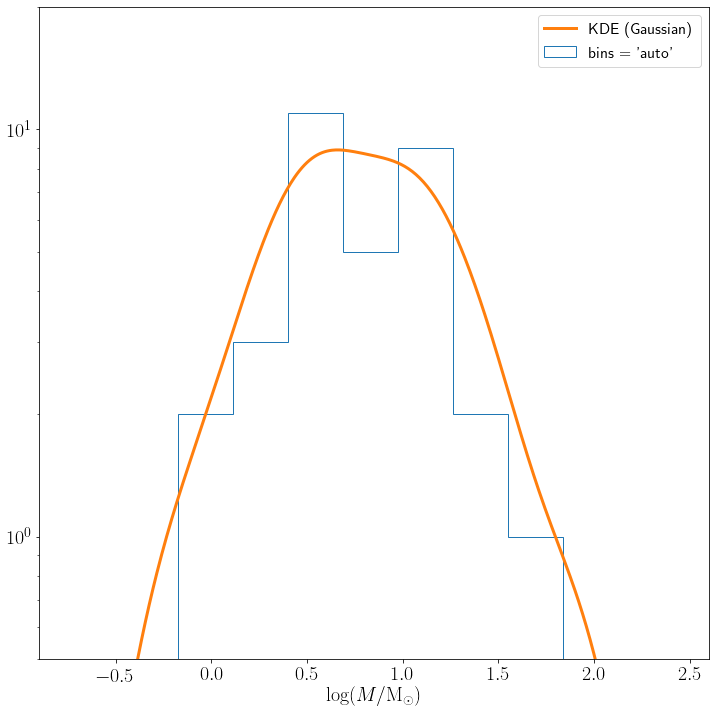

In [20]:
##########sixth, fit a KDE with automated binwidth determination
from statsmodels.nonparametric.kde import KDEUnivariate
kde = KDEUnivariate(log_m)
kde.fit() #compute the best-fit KDE to the data
#log_m_mode = kde.support[np.argmax(kde.density)] #location of the mode of the best-fit function
plt.figure(figsize = (12, 12))
h, bin_edges, _ = plt.hist(log_m, bins = 'auto', histtype = 'step', log = True, label = "bins = 'auto'")
plt.plot(kde.support, kde.density * max(h), lw = 3, label = 'KDE (Gaussian)')
plt.xlim(-0.9, 2.6); plt.ylim(0.5, 20)
plt.xlabel(r'$\log(M/{\rm M}_{\odot})$')
plt.legend(loc = 'best', prop = {'size': 16})


# We can generate uncertainties in the best-fit KDE using, e.g., Monte Carlo to generate thousands of realisations of the dataset and computing a KDE each time.

<Figure size 576x576 with 0 Axes>

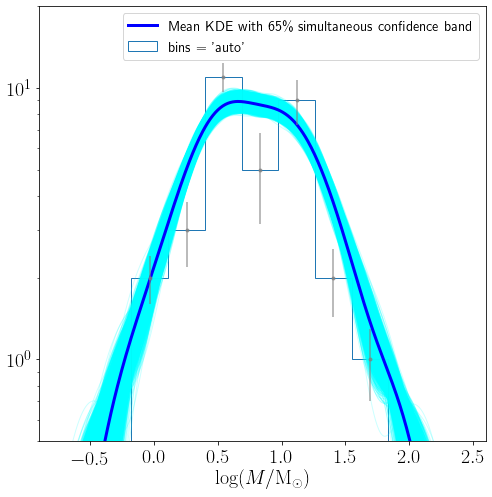

In [21]:
##########seventh, fit one KDE with automated binwidth determination to each realisation of the raw data
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy.stats import norm
kde = KDEUnivariate(log_m)
kde.fit() #compute the best-fit KDE to the data
support = kde.support
nsupport = len(support)
#density = kde.density * np.max(h_with_unc)
density = kde.density
ndata = len(log_m)
nreal = 10000 #number of realisations
rand = norm.rvs(size = (ndata, nreal))
#support_sim = np.zeros((nreal, len(support)))
density_sim = np.zeros((nreal, len(density)))
for i in range(nreal):
    log_m_sim = log_m + e_log_m * rand[:, i]
    kde = KDEUnivariate(log_m_sim)
    kde.fit()
    #evaluate the density on the same grid as the original fit
    #density_sim[i, :] = kde.evaluate(support) * np.max(h_with_unc)
    density_sim[i, :] = kde.evaluate(support)
#Compute the mean of nreal realisations
density_mean = density_sim.mean(axis = 0)
#The sum of absolute deviations from this mean density was found to be
#   approximately Gaussian within 2 standard deviations of the mean.
absdev = np.zeros(nreal)
for i in range(nreal):
    absdev[i] = (np.abs(density_sim[i, :] - density_mean)).sum()/nsupport
absdev_mean = absdev.mean()
absdev_std = absdev.std()
k = KDEUnivariate(absdev)
k.fit()
plt.figure(figsize = (12, 12))
plt.plot(k.support, k.density, lw = 3)
plt.xlim(absdev_mean - 6 * absdev_std, absdev_mean + 6 * absdev_std)
plt.title('Mean absolute deviations from the mean KDE')
plt.close()
#isolate models which are within 1 standard deviation of the mean KDE
j = np.nonzero(abs(absdev - absdev_mean) <= absdev_std)[0]
#First plot histogram with uncertainties
_ = plt.hist(log_m, bins = 'auto', histtype = 'step', log = True, label = "bins = 'auto'", density = True)
plt.errorbar(bin_centers_with_unc, h_with_unc, yerr = h_unc, fmt = '.', c = 'gray', alpha = 0.7, \
             zorder = 6)
#Now the KDE with uncertainties
for jj in range(len(j)):
    plt.plot(support, density_sim[j[jj], :], lw = 1, alpha = 0.2, color = 'cyan')
plt.plot(support, density_mean, lw = 3, color = 'blue', label = r'Mean KDE with 65\% simultaneous confidence band')
plt.xlim(-0.9, 2.6)#; plt.ylim(0.5, 20)
plt.xlabel(r'$\log(M/{\rm M}_{\odot})$')
plt.legend(loc = 'best')


# I first identified the mean KDE curve, then computed a mean absolute deviation from this for all the KDEs. By inspecting the distribution of the resulting deviations, I then chose only those KDEs that are within 1 standard deviation of the mean KDE. These are shown as the cyan envelope.

# Such a confidence band, which is derived by requiring that simultaneously comparing each point on a KDE to the mean KDE, is called a simultaneous confidence band.

# I could, instead, have required the value at each point to be within 1 standard deviation of the mean at that point. This generates a pointwise confidence band.

# In general, a simultaneous CB generates a narrower uncertainty envelope than a pointwise CB.
